In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r^2": r_score,}

In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21.0.1+12-LTS-29, mixed mode, sharing)
  Starting server from C:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\38066\AppData\Local\Temp\tmpjlx49bzu
  JVM stdout: C:\Users\38066\AppData\Local\Temp\tmpjlx49bzu\h2o_38066_started_from_python.out
  JVM stderr: C:\Users\38066\AppData\Local\Temp\tmpjlx49bzu\h2o_38066_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 19 days
H2O_cluster_name:,H2O_from_python_38066_h97mcq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.952 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [82]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    elif "angle" in feature_name or "distance" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:172, amount of features: 40
147 25
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [83]:
import numpy as np
import pandas as pd
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


ring_features = [feature_name for feature_name in X.columns if 'ring' in feature_name.lower()]
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']

for i in range(len(ring_features)):
    for j in range(len(ring_features)):
        first_feature = X[ring_features[i]]
        second_feature = X[ring_features[j]]

        if i == j:
            continue

        confusion_matrix = pd.crosstab(first_feature, second_feature)
        cramers_v_value = cramers_v(confusion_matrix.values)
        print(f"{ring_features[i]}, {ring_features[j]}, corr: {cramers_v_value}")

nFRing, nHRing, corr: 0.5799472743597861
nFRing, nARing, corr: 0.8557878388867258
nFRing, nFHRing, corr: 0.8090152479786314
nHRing, nFRing, corr: 0.5799472743597861
nHRing, nARing, corr: 0.6568999956701997
nHRing, nFHRing, corr: 0.7298992678284247
nARing, nFRing, corr: 0.8557878388867258
nARing, nHRing, corr: 0.6568999956701996
nARing, nFHRing, corr: 0.7758976171502688
nFHRing, nFRing, corr: 0.8090152479786314
nFHRing, nHRing, corr: 0.7298992678284247
nFHRing, nARing, corr: 0.775897617150269


In [84]:
x = train.columns
y = "logP"
x.remove(y)

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |
21:49:51.160: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
21:49:51.162: AutoML: XGBoost is not available; skipping it.
21:49:51.273: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 147.0.

██████

█████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse        mse       mae      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_3_AutoML_2_20240208_214951  0.240342  0.0577642  0.185436  0.0858265                 0.0577642
StackedEnsemble_BestOfFamily_5_AutoML_2_20240208_214951  0.241706  0.0584218  0.186075  0.0865031                 0.0584218
StackedEnsemble_BestOfFamily_6_AutoML_2_20240208_214951  0.242539  0.0588251  0.185751  0.0863326                 0.0588251
GLM_1_AutoML_2_20240208_214951                           0.245266  0.0601552  0.189784  0.0859409                 0.0601552
DeepLearning_grid_1_AutoML_2_20240208_214951_model_17    0.248156  0.0615813  0.191091  0.0903419                 0.0615813
DeepLearning_grid_1_AutoML_2_20240208_214951_model_44    0.248228  0.0616172  0.195224  0.0874555                 0.0616172
StackedEnsemble_BestOfFamily_1_AutoML_2_20240208_214951  0.24

TRAIN

In [85]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.025, 'mae': 0.115, 'r^2': 0.921}

OOS

In [86]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.016, 'mae': 0.104, 'r^2': 0.939}

BEST_MODEL(for cross-val metrics)

In [87]:
best_model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/5
# GBM base models (used / total),1/1
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),0/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,fold_id


PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


C:\Users\38066\AppData\Local\Temp\ipykernel_26988\1575081460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

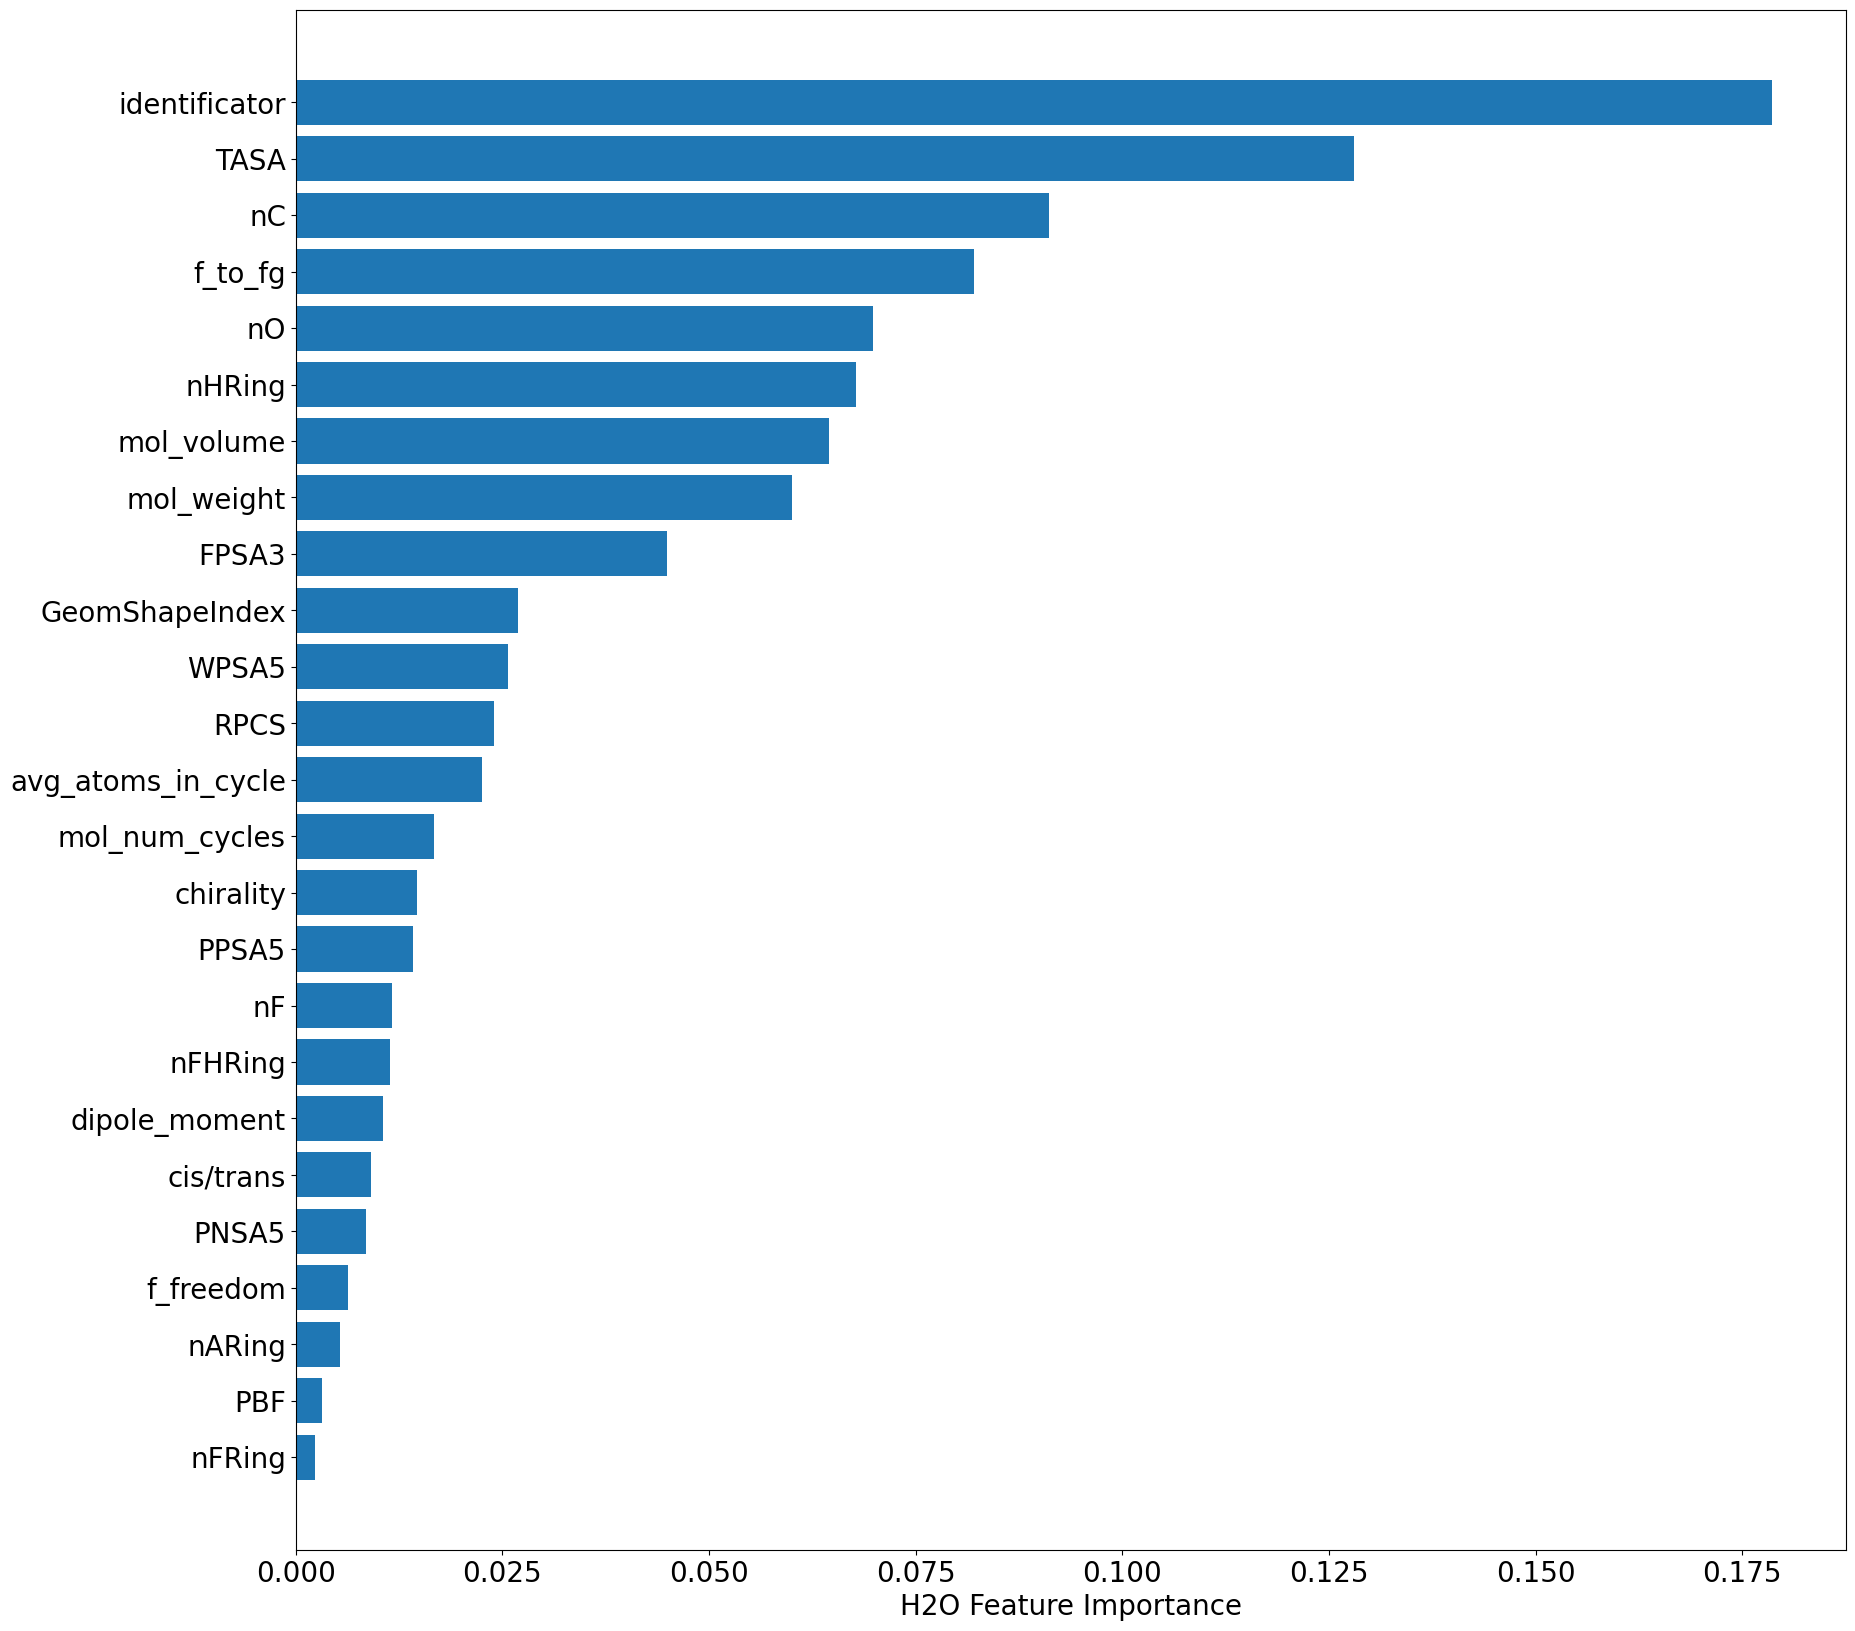

In [88]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

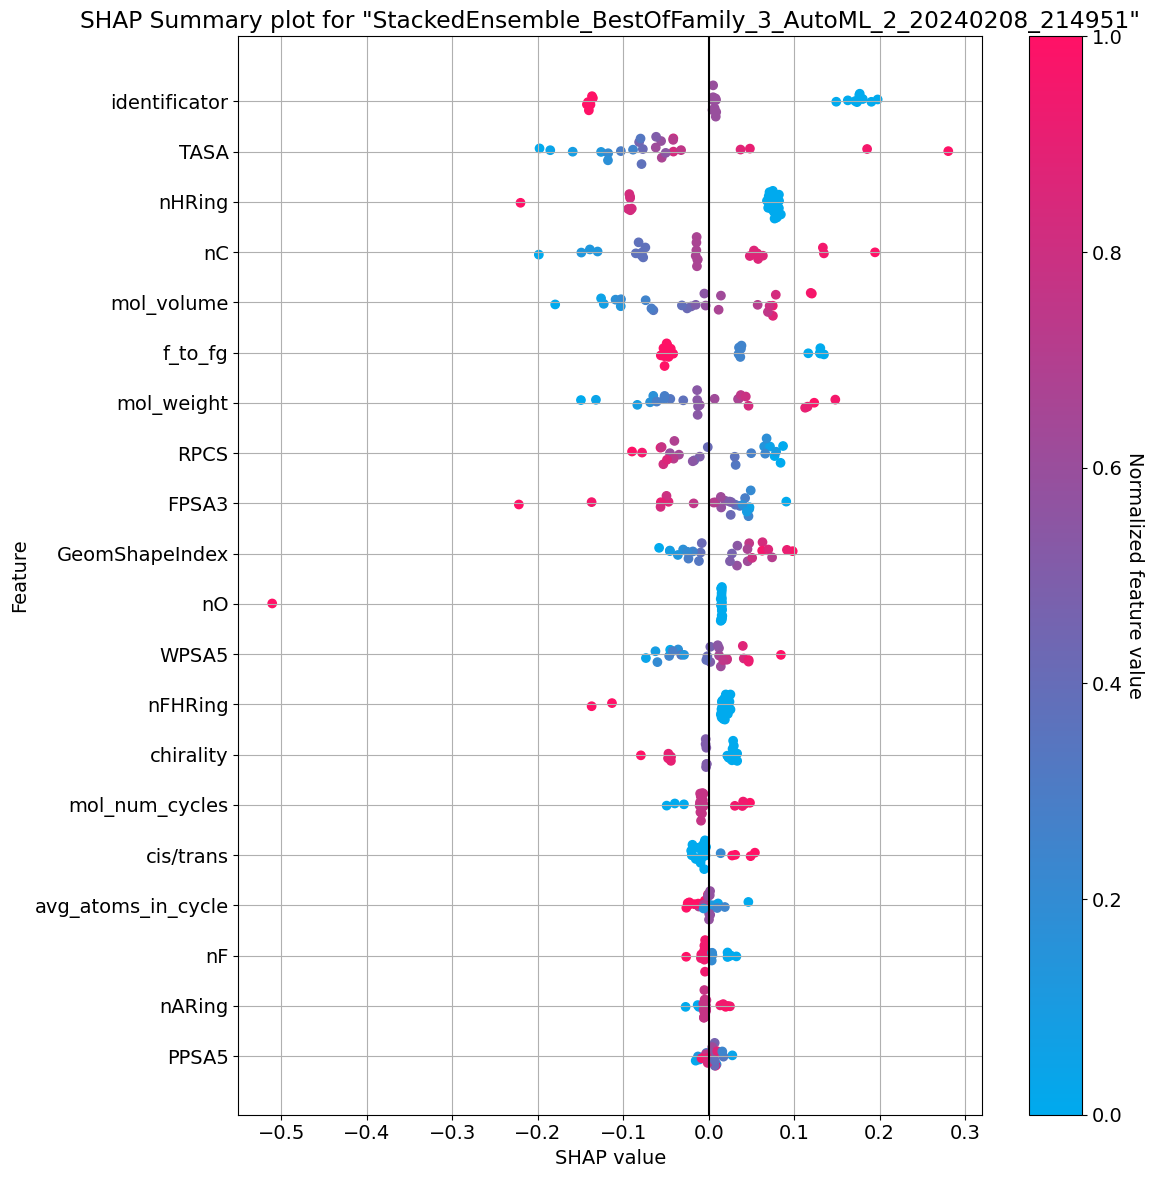

In [89]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=1000)

VAR IMPORTANCE

In [90]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

importance = best_model.varimp(test)

if importance is not None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
    ax.set_xlabel('Percent')


In [91]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\08.02.24_feature_2.2\logP'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'all_molecules(without_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\logP\\all_molecules(without_angle_feature)_without_outliers\\StackedEnsemble_BestOfFamily_3_AutoML_2_20240208_214951'

---------------

------------

--------------

------------

----

Molecules only with dihedral angle, with angles as features

In [92]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

outliers_features_to_skip = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=outliers_features_to_skip)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:106, amount of features: 40
90 16
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [93]:
x = train.columns
y = "logP"
x.remove(y)

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |
22:47:01.546: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
22:47:01.547: AutoML: XGBoost is not available; skipping it.
22:47:01.616: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 90.0.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse        mse       mae      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_5_AutoML_3_20240208_224701  0.239363  0.0572947  0.172815  0.0887901                 0.0572947
DeepLearning_grid_1_AutoML_3_20240208_224701_model_186   0.243754  0.0594158  0.178151  0.0869123                 0.0594158
DeepLearning_grid_1_AutoML_3_20240208_224701_model_19    0.249087  0.0620444  0.189796  0.0923423                 0.0620444
DeepLearning_grid_1_AutoML_3_20240208_224701_model_253   0.251579  0.0632918  0.187438  0.0

TRAIN

In [94]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.005, 'mae': 0.054, 'r^2': 0.983}

OOS

In [95]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.025, 'mae': 0.134, 'r^2': 0.887}

BEST_MODEL(for cross-val metrics)

In [96]:
best_model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/5
# GBM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),1/1
# DRF base models (used / total),0/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,fold_id


PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


C:\Users\38066\AppData\Local\Temp\ipykernel_26988\1575081460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

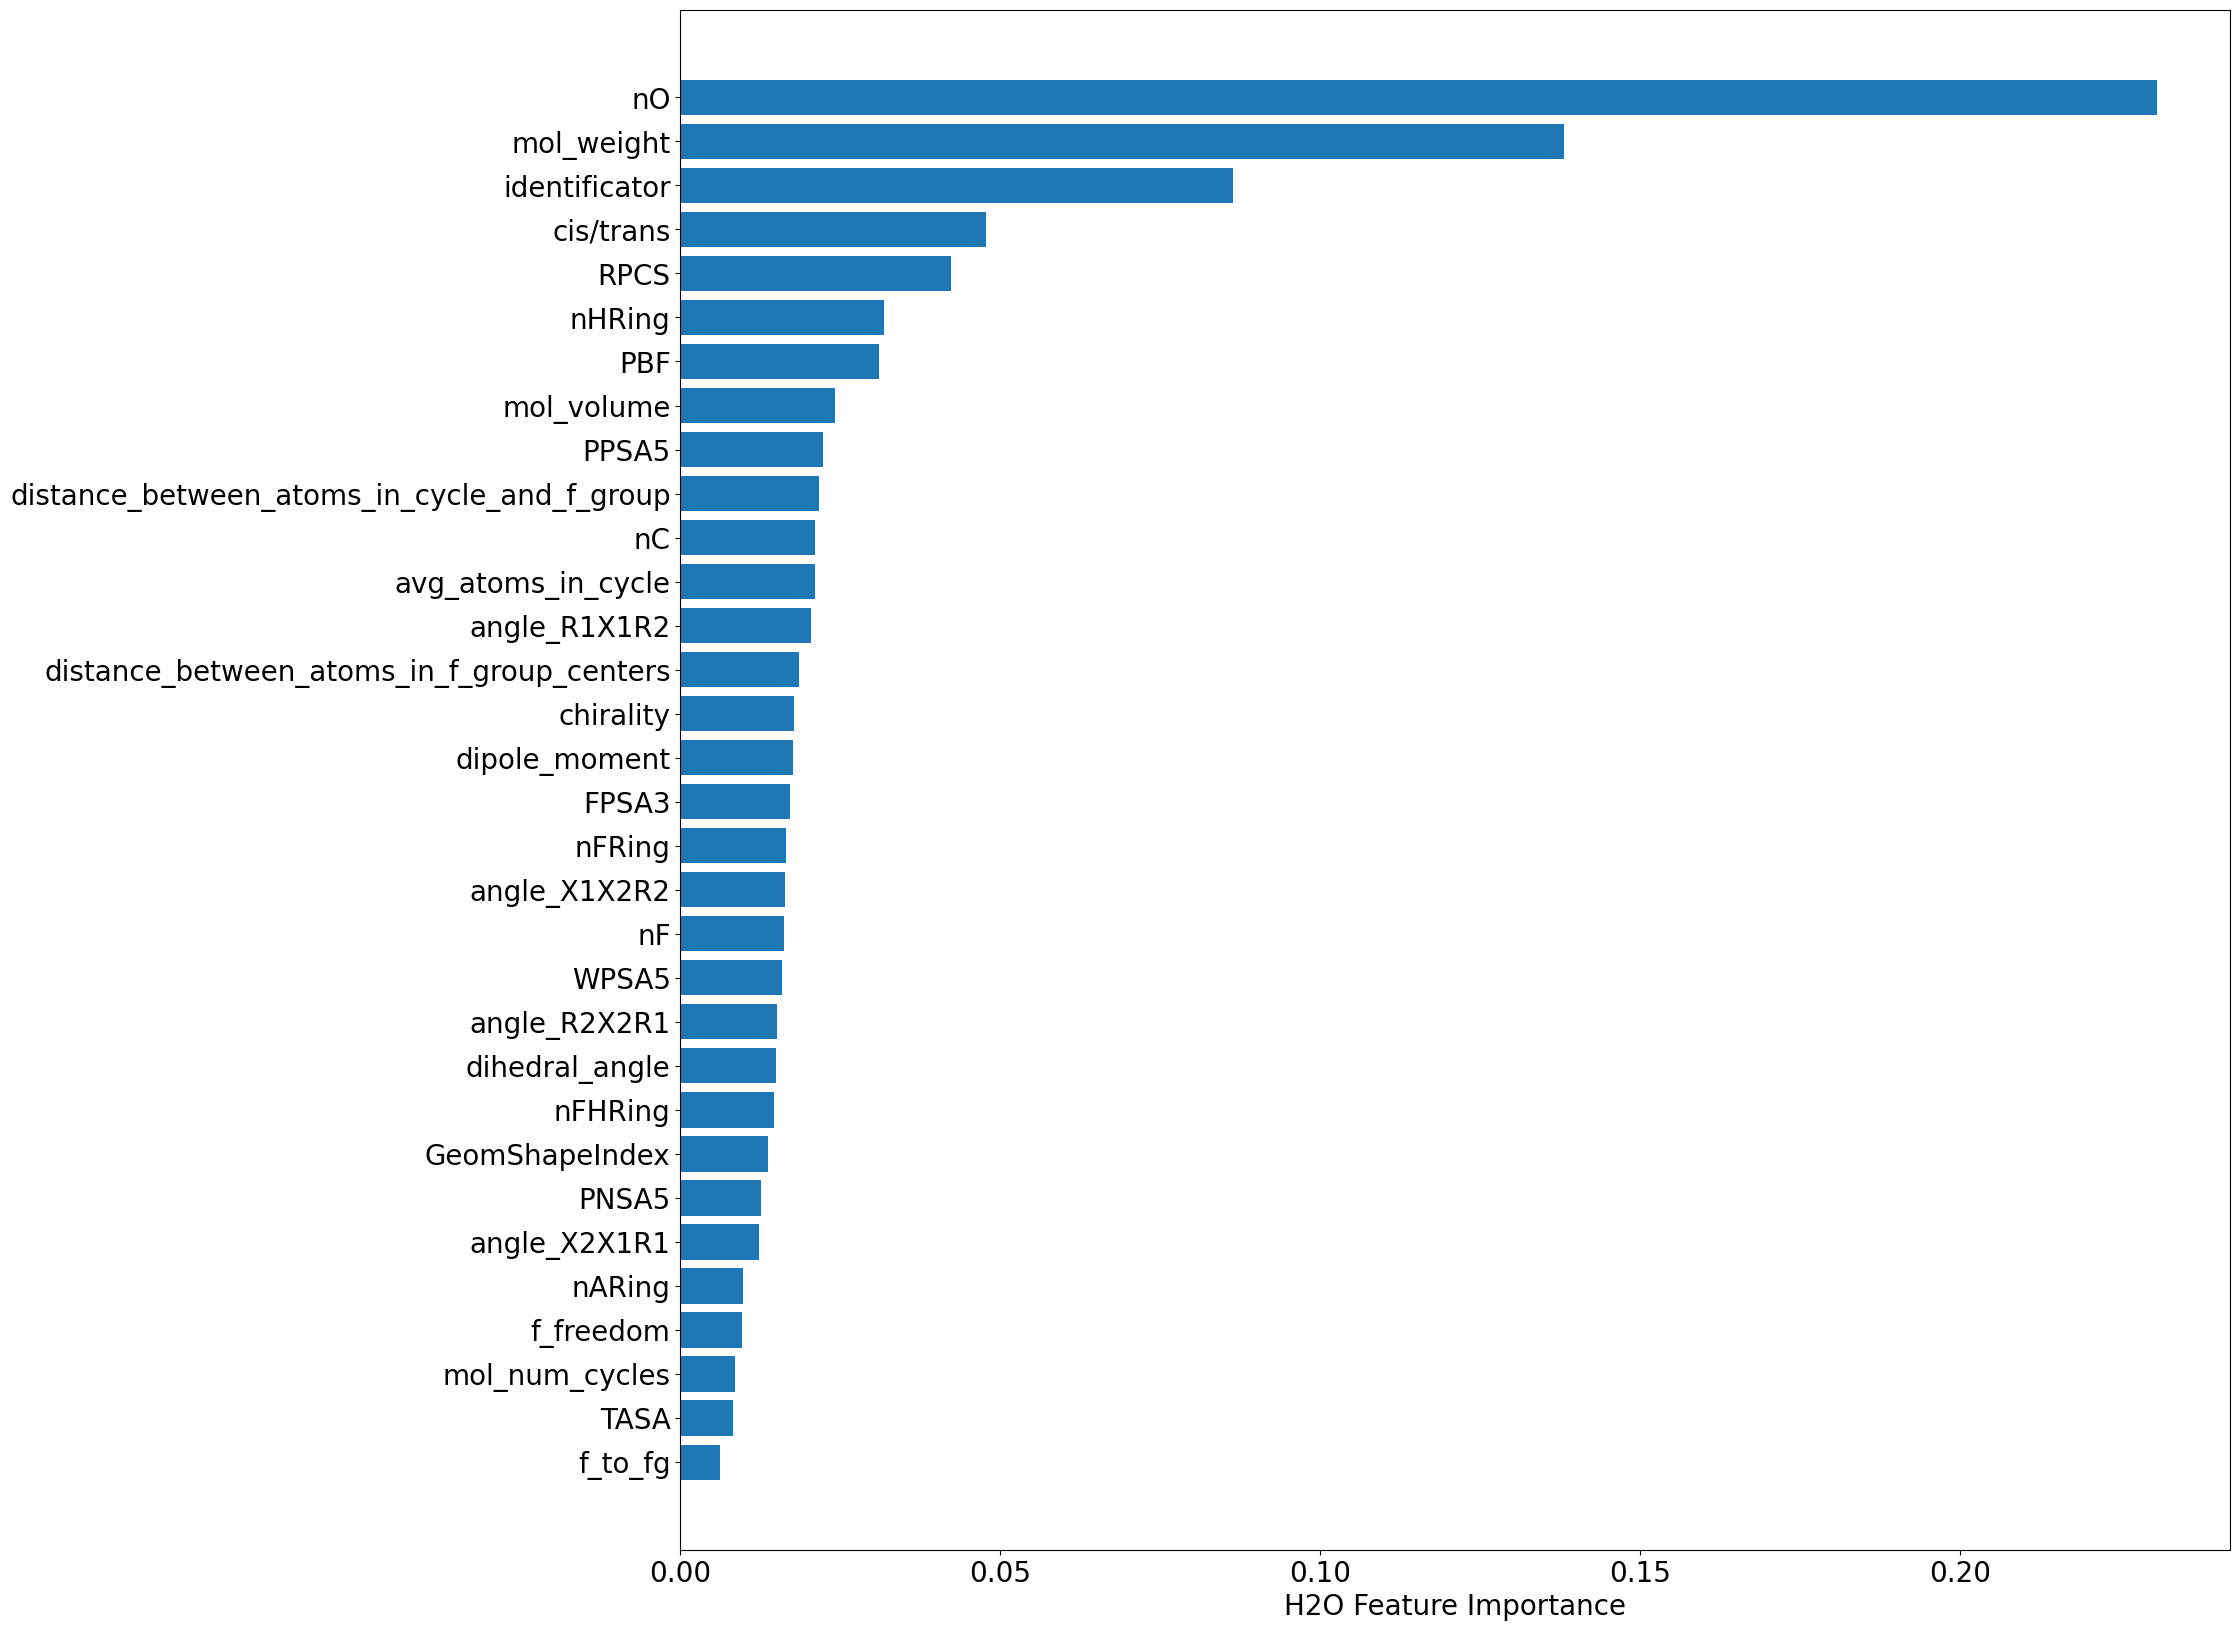

In [97]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

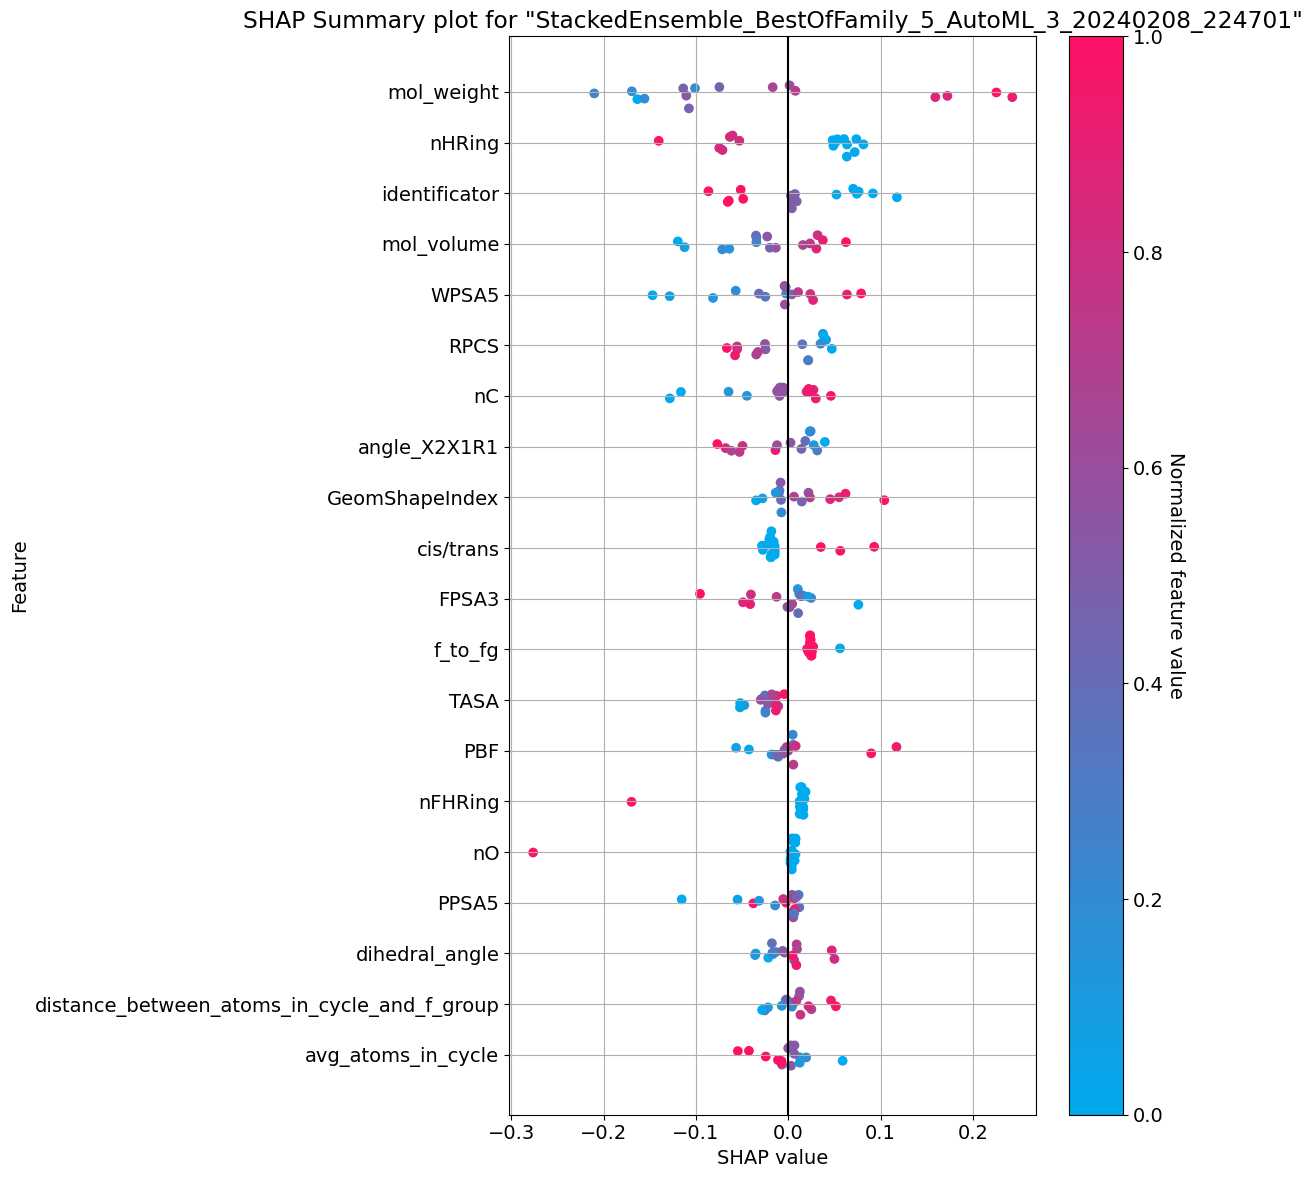

In [98]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=1000)

VAR IMPORTANCE

In [99]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

importance = best_model.varimp(test)

if importance is not None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
    ax.set_xlabel('Percent')


In [100]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\08.02.24_feature_2.2\logP'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'only_molecules_with_dihedral_angle(with_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\logP\\only_molecules_with_dihedral_angle(with_angle_feature)_without_outliers\\StackedEnsemble_BestOfFamily_5_AutoML_3_20240208_224701'

---------------

--------------

--------

------------

------------

In [101]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

outliers_features_to_skip = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=outliers_features_to_skip)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    elif "angle" in feature_name or "distance" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:106, amount of features: 40
90 16
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [102]:
x = train.columns
y = "logP"
x.remove(y)

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |
23:45:50.587: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
23:45:50.587: AutoML: XGBoost is not available; skipping it.
23:45:50.634: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 90.0.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse        mse       mae      rmsle    mean_residual_deviance
DeepLearning_grid_3_AutoML_4_20240208_234550_model_59    0.248192  0.0615991  0.180693  0.0906104                 0.0615991
DeepLearning_grid_2_AutoML_4_20240208_234550_model_97    0.252272  0.0636409  0.188628  0.092292                  0.0636409
GBM_grid_1_AutoML_4_20240208_234550_model_1463           0.25405   0.0645416  0.195107  0.0909581                 0.0645416
StackedEnsemble_BestOfFamily_6_AutoML_4_20240208_234550  0.254995  0.0650222  0.185802  0.0

TRAIN

In [103]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.017, 'mae': 0.098, 'r^2': 0.944}

OOS

In [104]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.016, 'mae': 0.098, 'r^2': 0.927}

BEST_MODEL(for cross-val metrics)

In [105]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_3_AutoML_4_20240208_234550_model_59


Status of Neuron Layers: predicting logP, regression, gaussian distribution, Quadratic loss, 22 901 weights/biases, 278,8 KB, 900 900 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate               rate_rms               momentum    mean_weight            weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ----------------------  ---------------------  ----------  ---------------------  -------------------  --------------------  -----------------------
    1        25       Input             15.0
    2        100      RectifierDropout  40.0       0.0   0.0   0.002144700483989436    0.0014205235056579113  0.0         0.01125576374369557    0.13811784982681274  0.2706861743312002    0.1381351351737976
    3        100      RectifierDropout  40.0       0.0   0.0   0.003264502711649402    0.0018197367899119854  0.0         -0.017155376321762377  0.10441413521766663  0.8315909154667825    0.11985468864440918
    4        100      RectifierDropout  40.0       0.0   0.0   0.0036180490365804873   0.003064689226448536   0.0         -0.026811502433751775  0.09861242771148682  1.0455115981282577    0.06123495101928711
    5        1        Linear                       0.0   0.0   0.00024283429214847274  9.935093112289906e-05  0.0         -0.002030412945896387  0.09073162078857422  -0.03916462758581388  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.017361679825592943
RMSE: 0.13176372727572996
MAE: 0.09835093784742081
RMSLE: 0.055718537121225514
Mean Residual Deviance: 0.017361679825592943

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.0615991248153882
RMSE: 0.24819170980390984
MAE: 0.18069334193988265
RMSLE: 0.09061040136527876
Mean Residual Deviance: 0.0615991248153882

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid
----------------------  ---------  ----------  ------------  ------------
mae                     0.181184   0.0156274   0.170134      0.192235
mean_residual_deviance  0.0618098  0.00670449  0.057069      0.0665506
mse                     0.0618098  0.00670449  0.057069      0.0665506
r2                      0.799948   0.0302763   0.821356      0.778539
residual_deviance       0.0618098  0.00670449  0.057069      0.0665506
rmse                    0.248433   0.0134936   0.238891      0.257974
rmsle                   0.0905183  0.00241835  0.0922283     0.0888083

Scoring History: 
    timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2024-02-09 00:34:18  0.000 sec                            0         0             0          nan              nan                  nan             nan
    2024-02-09 00:34:18  21 min 32.700 sec  25000 obs/sec     10        1             900        0.649469         0.42181              0.540653        -0.358261
    2024-02-09 00:34:23  21 min 37.701 sec  24131 obs/sec     1350      135           121500     0.149897         0.0224691            0.109632        0.927648
    2024-02-09 00:34:28  21 min 42.705 sec  29321 obs/sec     3270      327           294300     0.12413          0.0154083            0.0903479       0.950384
    2024-02-09 00:34:33  21 min 47.707 sec  32021 obs/sec     5350      535           481500     0.12906          0.0166566            0.0950342       0.946364
    2024-02-09 00:34:38  21 min 52.713 sec  33725 obs/sec     7510      751           675900     0.122991         0.0151269            0.08803

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


C:\Users\38066\AppData\Local\Temp\ipykernel_26988\1575081460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

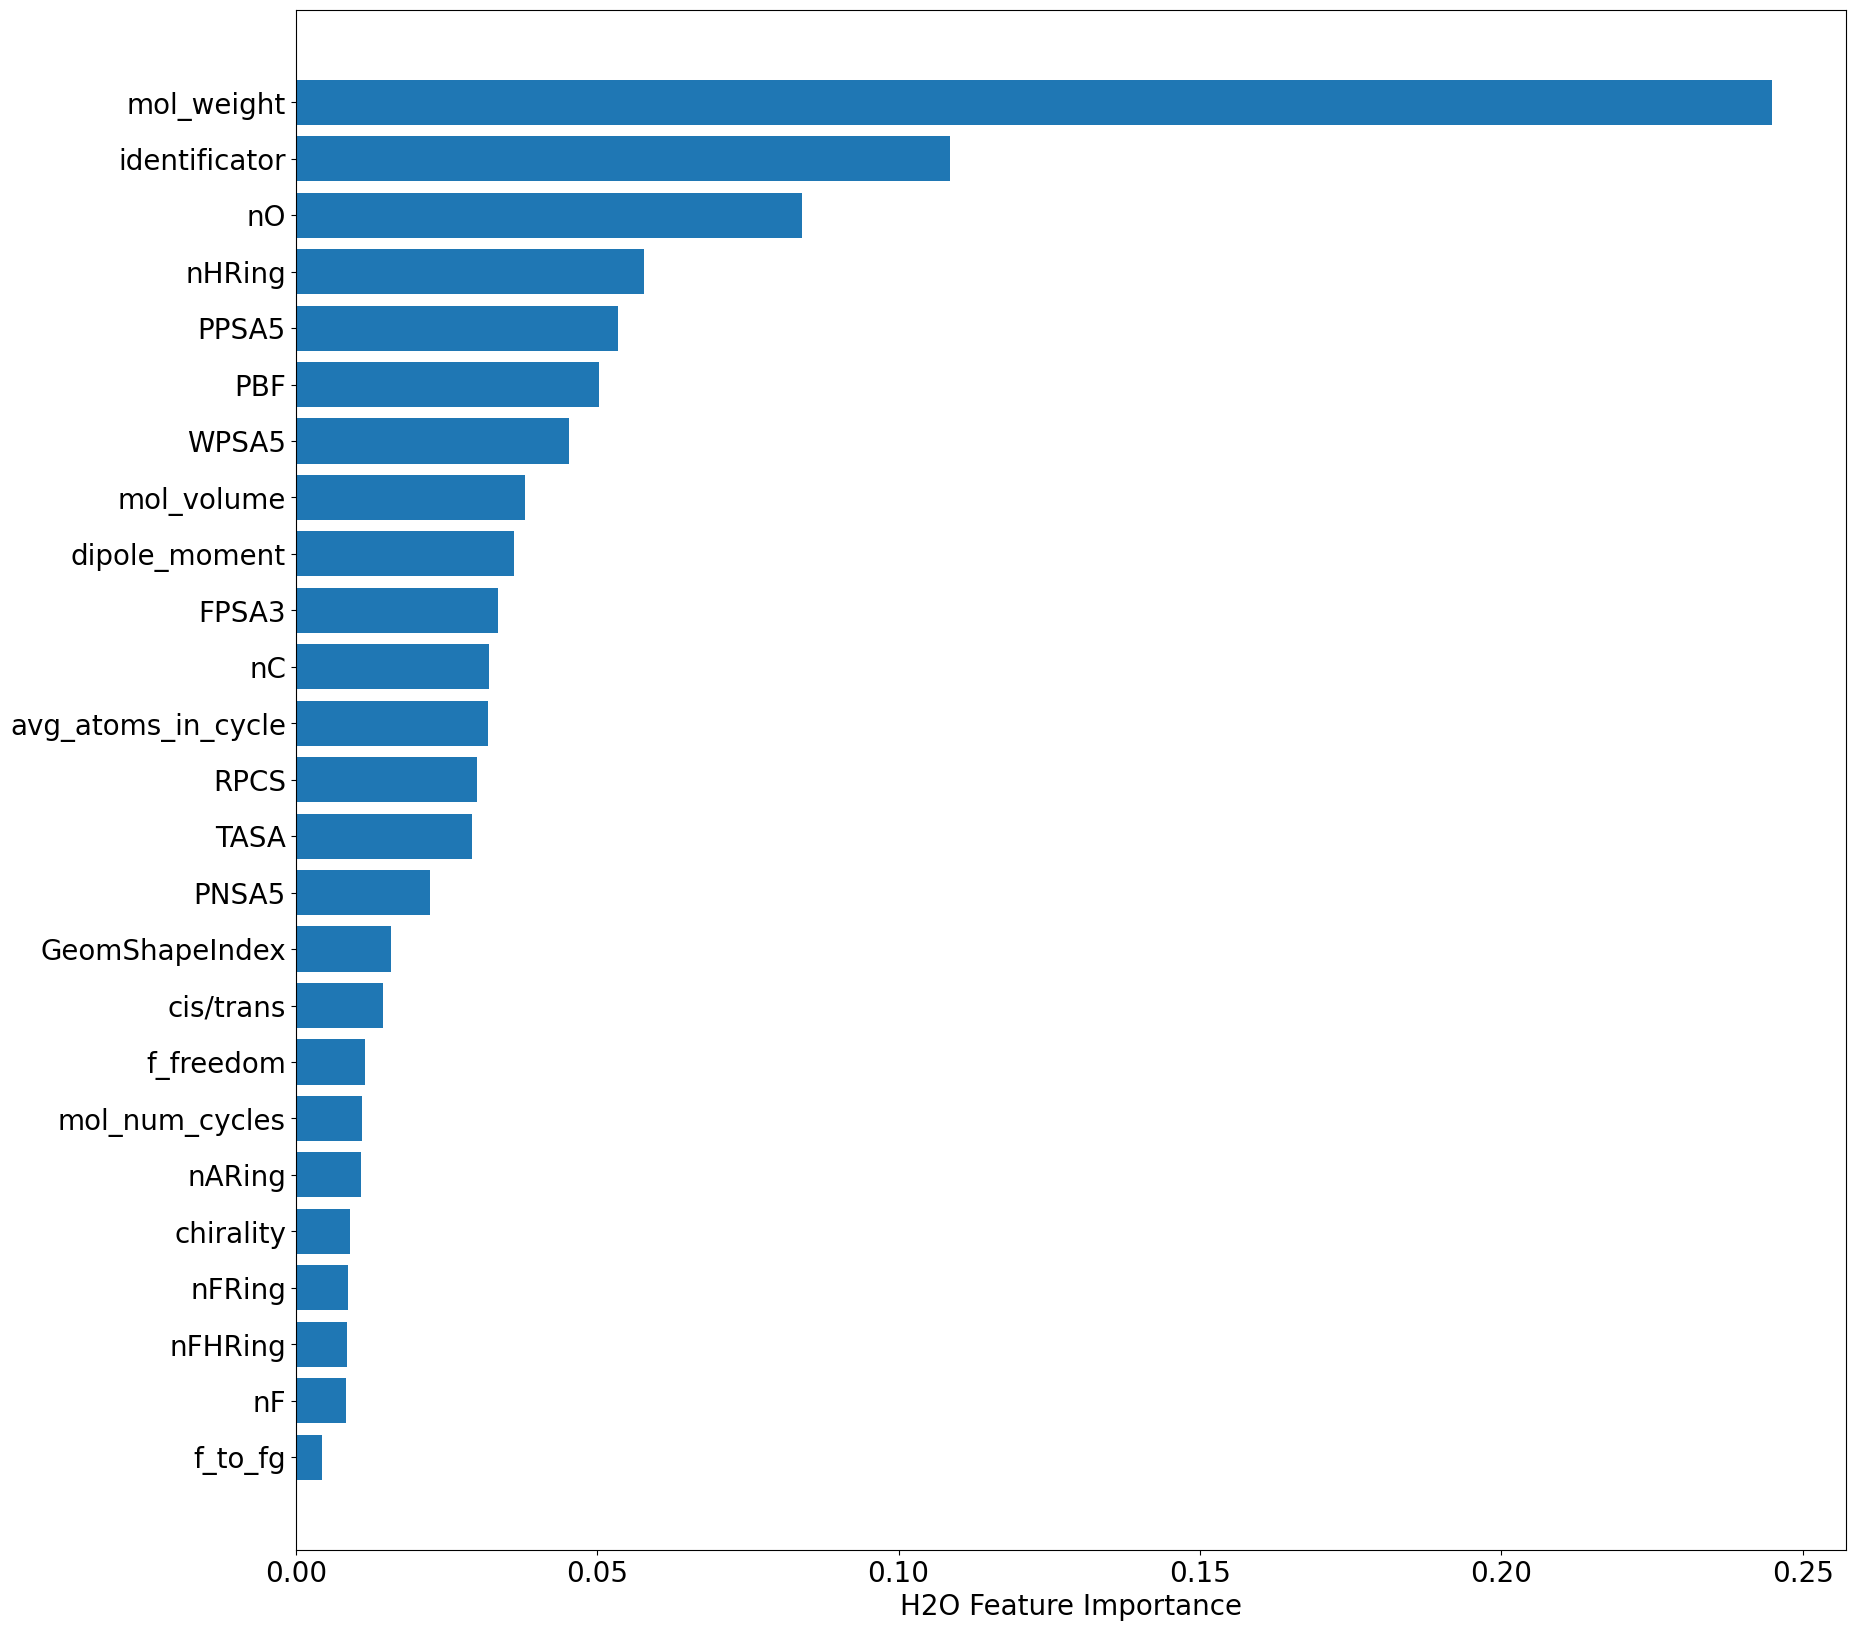

In [106]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

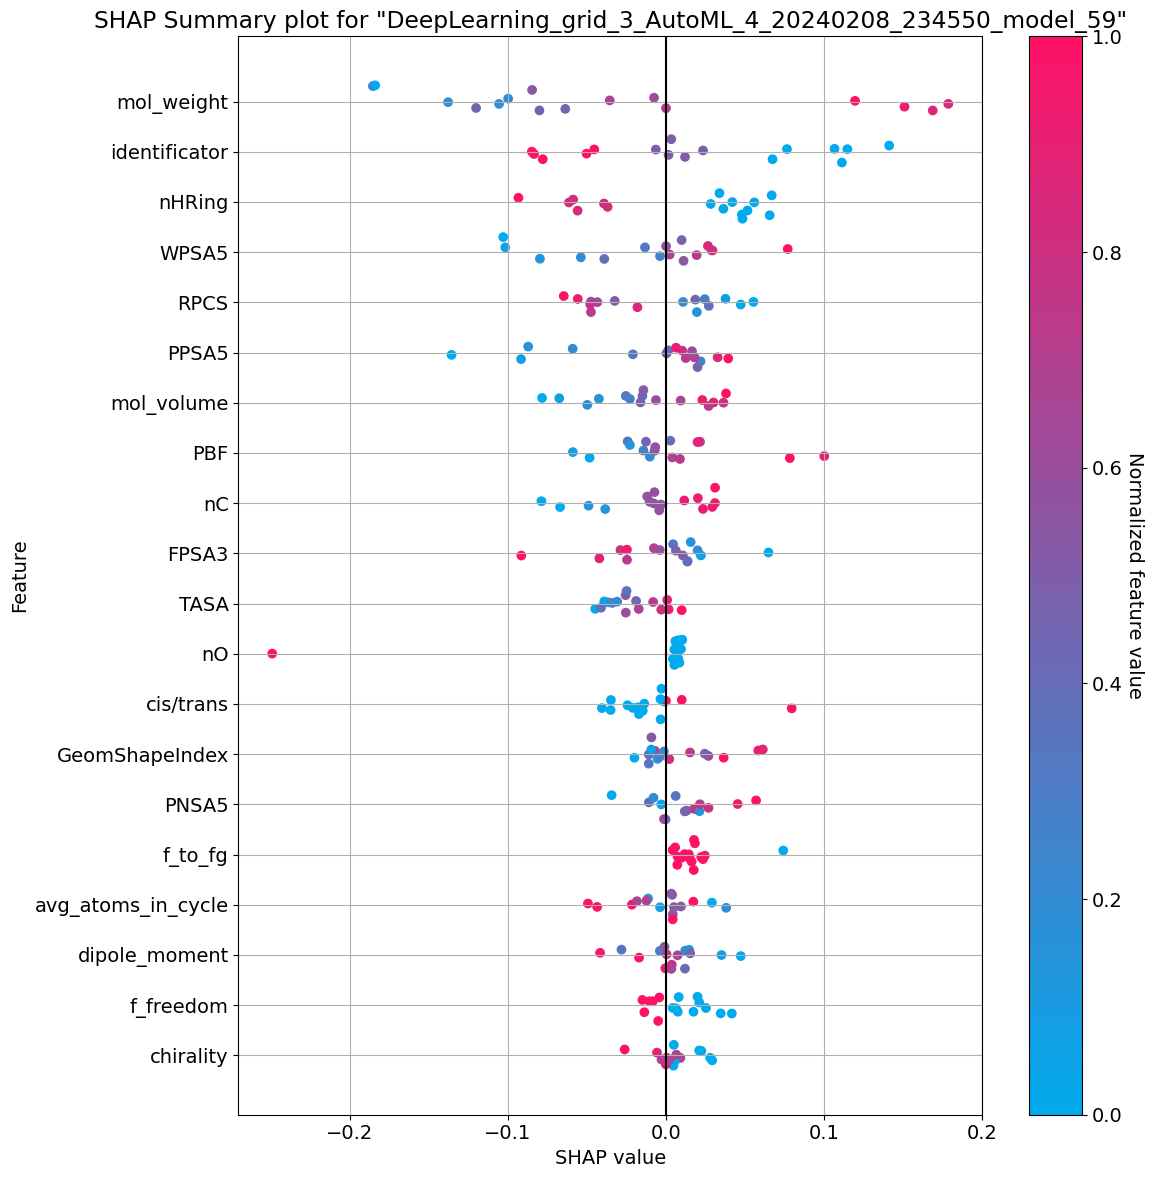

In [107]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=1000)

VAR IMPORTANCE

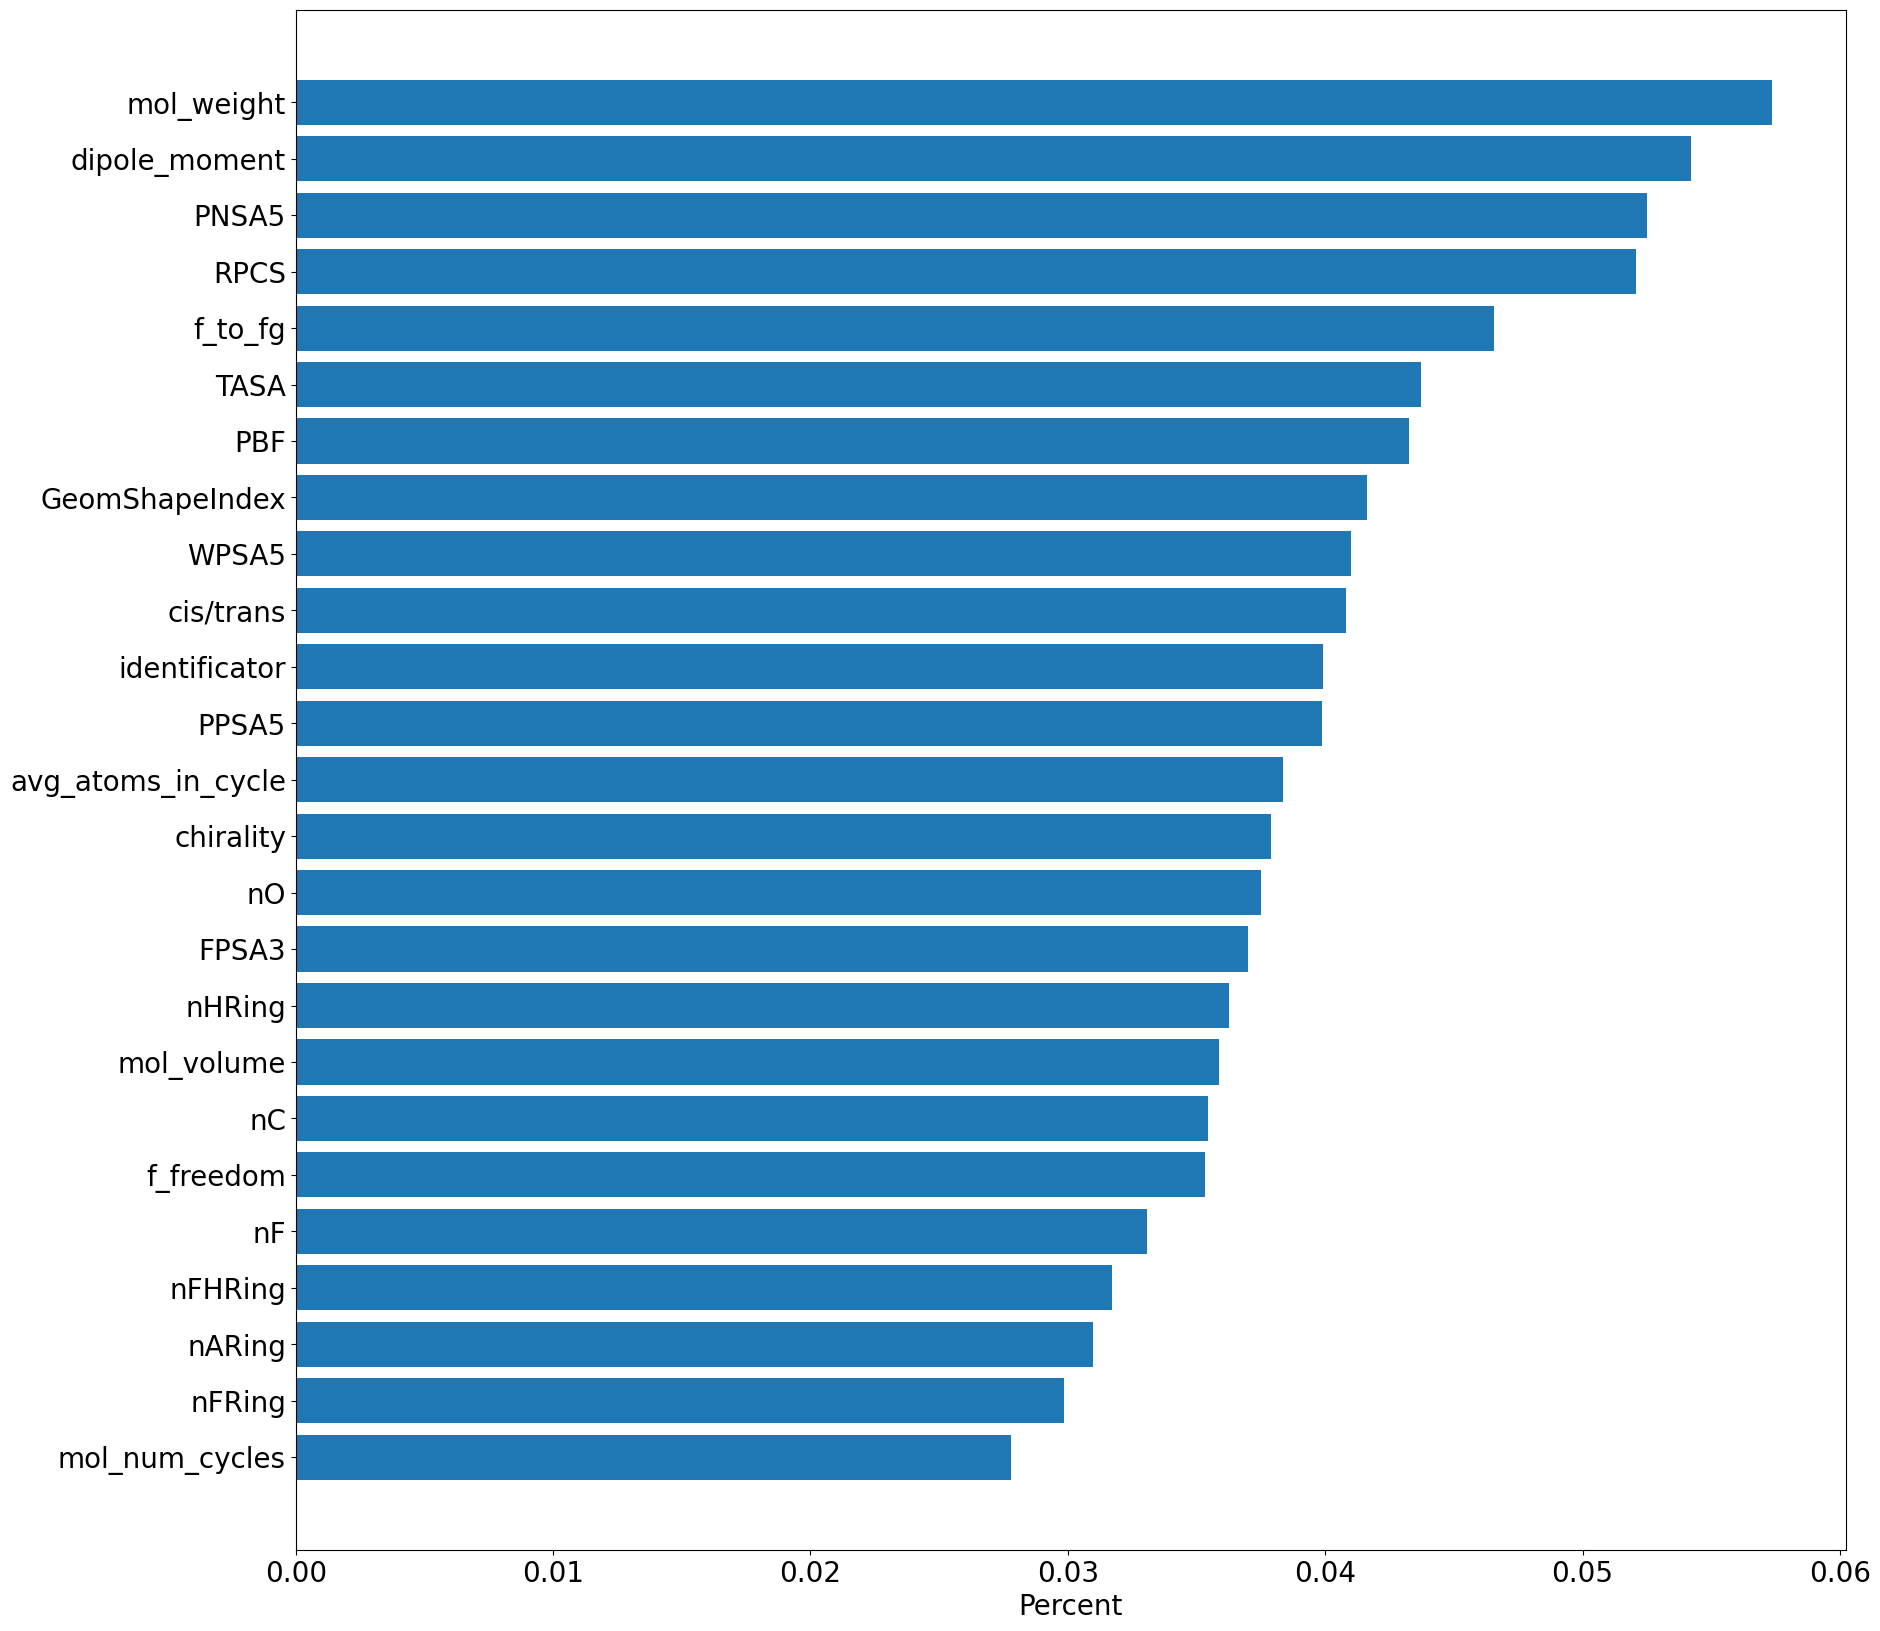

In [108]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

importance = best_model.varimp(test)

if importance is not None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
    ax.set_xlabel('Percent')


In [109]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\08.02.24_feature_2.2\logP'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'only_molecules_with_dihedral_angle(without_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\logP\\only_molecules_with_dihedral_angle(without_angle_feature)_without_outliers\\DeepLearning_grid_3_AutoML_4_20240208_234550_model_59'